In [1]:
import json
import random
from tqdm import tqdm
import numpy as np

from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

import torch

from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

# Что делать?
Где есть пометка # CODE писать код

[Полезный туториал](http://jalammar.github.io/illustrated-word2vec/)

# Загружаем данные
Они уже обработанные и токенизированные. Процесс можно посмотреть в тетрадке 1.1 Processing corpus

In [2]:
with open('data/processed_corpus.json') as f:
    corpus = json.load(f)

In [3]:
len(corpus)

100000

In [4]:
for text in corpus[:5]:
    print(' '.join(text))

второй UNK год окончательно разочаровать решить податься альфабанк
вернуть денежный средство лицевой счёт либо зачесть счёт погашение кредит
притом ситуация решиться участие течение сутки заявить
мой ##число летний жизнь это самый неповоротливый работник банк который видеть
везде написать вклад принимать очередь это


# CBOW

In [5]:
sample_text = corpus[1]

In [6]:
' '.join(sample_text)

'вернуть денежный средство лицевой счёт либо зачесть счёт погашение кредит'

In [7]:
sample_text

['вернуть',
 'денежный',
 'средство',
 'лицевой',
 'счёт',
 'либо',
 'зачесть',
 'счёт',
 'погашение',
 'кредит']

# Реализуйте разделение предложения на примеры методом CBOW

In [8]:
def cbow_split(tokens, window, pad_token='PAD'):
    
    splits = []

    padding = [pad_token] * window
    padded_tokens = padding + tokens + padding
    for i in range(window, len(padded_tokens)-window):
        central_word = padded_tokens[i]
        left_window = padded_tokens[i-window: i]
        right_window = padded_tokens[i+1: i+window+1]
        print(central_word, left_window, right_window)
        splits.append((left_window, central_word, right_window))
    return splits

In [9]:
splits = cbow_split(sample_text, window=2)

вернуть ['PAD', 'PAD'] ['денежный', 'средство']
денежный ['PAD', 'вернуть'] ['средство', 'лицевой']
средство ['вернуть', 'денежный'] ['лицевой', 'счёт']
лицевой ['денежный', 'средство'] ['счёт', 'либо']
счёт ['средство', 'лицевой'] ['либо', 'зачесть']
либо ['лицевой', 'счёт'] ['зачесть', 'счёт']
зачесть ['счёт', 'либо'] ['счёт', 'погашение']
счёт ['либо', 'зачесть'] ['погашение', 'кредит']
погашение ['зачесть', 'счёт'] ['кредит', 'PAD']
кредит ['счёт', 'погашение'] ['PAD', 'PAD']


In [10]:
for sample in splits:
    print('Левый контекст:', sample[0])
    print('Центральное слово:', sample[1])
    print('Правый контекст:', sample[2], end='\n\n')

Левый контекст: ['PAD', 'PAD']
Центральное слово: вернуть
Правый контекст: ['денежный', 'средство']

Левый контекст: ['PAD', 'вернуть']
Центральное слово: денежный
Правый контекст: ['средство', 'лицевой']

Левый контекст: ['вернуть', 'денежный']
Центральное слово: средство
Правый контекст: ['лицевой', 'счёт']

Левый контекст: ['денежный', 'средство']
Центральное слово: лицевой
Правый контекст: ['счёт', 'либо']

Левый контекст: ['средство', 'лицевой']
Центральное слово: счёт
Правый контекст: ['либо', 'зачесть']

Левый контекст: ['лицевой', 'счёт']
Центральное слово: либо
Правый контекст: ['зачесть', 'счёт']

Левый контекст: ['счёт', 'либо']
Центральное слово: зачесть
Правый контекст: ['счёт', 'погашение']

Левый контекст: ['либо', 'зачесть']
Центральное слово: счёт
Правый контекст: ['погашение', 'кредит']

Левый контекст: ['зачесть', 'счёт']
Центральное слово: погашение
Правый контекст: ['кредит', 'PAD']

Левый контекст: ['счёт', 'погашение']
Центральное слово: кредит
Правый контекст: [

In [11]:
splits

[(['PAD', 'PAD'], 'вернуть', ['денежный', 'средство']),
 (['PAD', 'вернуть'], 'денежный', ['средство', 'лицевой']),
 (['вернуть', 'денежный'], 'средство', ['лицевой', 'счёт']),
 (['денежный', 'средство'], 'лицевой', ['счёт', 'либо']),
 (['средство', 'лицевой'], 'счёт', ['либо', 'зачесть']),
 (['лицевой', 'счёт'], 'либо', ['зачесть', 'счёт']),
 (['счёт', 'либо'], 'зачесть', ['счёт', 'погашение']),
 (['либо', 'зачесть'], 'счёт', ['погашение', 'кредит']),
 (['зачесть', 'счёт'], 'погашение', ['кредит', 'PAD']),
 (['счёт', 'погашение'], 'кредит', ['PAD', 'PAD'])]

# Expected

```python
[(['PAD', 'PAD'], 'вопрос', ['почему', 'например']),
 (['PAD', 'вопрос'], 'почему', ['например', 'китайский']),
 (['вопрос', 'почему'], 'например', ['китайский', 'японский']),
 (['почему', 'например'], 'китайский', ['японский', 'UNK']),
 (['например', 'китайский'], 'японский', ['UNK', 'PAD']),
 (['китайский', 'японский'], 'UNK', ['PAD', 'PAD'])]
```

In [12]:
cbow_split(sample_text, window=3)

вернуть ['PAD', 'PAD', 'PAD'] ['денежный', 'средство', 'лицевой']
денежный ['PAD', 'PAD', 'вернуть'] ['средство', 'лицевой', 'счёт']
средство ['PAD', 'вернуть', 'денежный'] ['лицевой', 'счёт', 'либо']
лицевой ['вернуть', 'денежный', 'средство'] ['счёт', 'либо', 'зачесть']
счёт ['денежный', 'средство', 'лицевой'] ['либо', 'зачесть', 'счёт']
либо ['средство', 'лицевой', 'счёт'] ['зачесть', 'счёт', 'погашение']
зачесть ['лицевой', 'счёт', 'либо'] ['счёт', 'погашение', 'кредит']
счёт ['счёт', 'либо', 'зачесть'] ['погашение', 'кредит', 'PAD']
погашение ['либо', 'зачесть', 'счёт'] ['кредит', 'PAD', 'PAD']
кредит ['зачесть', 'счёт', 'погашение'] ['PAD', 'PAD', 'PAD']


[(['PAD', 'PAD', 'PAD'], 'вернуть', ['денежный', 'средство', 'лицевой']),
 (['PAD', 'PAD', 'вернуть'], 'денежный', ['средство', 'лицевой', 'счёт']),
 (['PAD', 'вернуть', 'денежный'], 'средство', ['лицевой', 'счёт', 'либо']),
 (['вернуть', 'денежный', 'средство'], 'лицевой', ['счёт', 'либо', 'зачесть']),
 (['денежный', 'средство', 'лицевой'], 'счёт', ['либо', 'зачесть', 'счёт']),
 (['средство', 'лицевой', 'счёт'], 'либо', ['зачесть', 'счёт', 'погашение']),
 (['лицевой', 'счёт', 'либо'], 'зачесть', ['счёт', 'погашение', 'кредит']),
 (['счёт', 'либо', 'зачесть'], 'счёт', ['погашение', 'кредит', 'PAD']),
 (['либо', 'зачесть', 'счёт'], 'погашение', ['кредит', 'PAD', 'PAD']),
 (['зачесть', 'счёт', 'погашение'], 'кредит', ['PAD', 'PAD', 'PAD'])]

# Expected

```python
[(['PAD', 'PAD', 'PAD'], 'вопрос', ['почему', 'например', 'китайский']),
 (['PAD', 'PAD', 'вопрос'], 'почему', ['например', 'китайский', 'японский']),
 (['PAD', 'вопрос', 'почему'], 'например', ['китайский', 'японский', 'UNK']),
 (['вопрос', 'почему', 'например'], 'китайский', ['японский', 'UNK', 'PAD']),
 (['почему', 'например', 'китайский'], 'японский', ['UNK', 'PAD', 'PAD']),
 (['например', 'китайский', 'японский'], 'UNK', ['PAD', 'PAD', 'PAD'])]
```

# Skipgram

In [13]:
' '.join(sample_text)

'вернуть денежный средство лицевой счёт либо зачесть счёт погашение кредит'

# Реализуйте разделение предложения на примеры методом Skipgram

In [14]:
def skipgram_split(tokens, window):
    
    splits = []
    
    for i in range(len(tokens)):
        context = tokens[max(0, i-window): i] + tokens[i+1: i+window+1]
        for w in context:
            splits.append((w, tokens[i]))
    return splits

In [15]:
splits = skipgram_split(sample_text, window=2)

In [16]:
for sample in splits:
    print('Контекст:', sample[0])
    print('Центральное слово:', sample[1], end='\n\n')

Контекст: денежный
Центральное слово: вернуть

Контекст: средство
Центральное слово: вернуть

Контекст: вернуть
Центральное слово: денежный

Контекст: средство
Центральное слово: денежный

Контекст: лицевой
Центральное слово: денежный

Контекст: вернуть
Центральное слово: средство

Контекст: денежный
Центральное слово: средство

Контекст: лицевой
Центральное слово: средство

Контекст: счёт
Центральное слово: средство

Контекст: денежный
Центральное слово: лицевой

Контекст: средство
Центральное слово: лицевой

Контекст: счёт
Центральное слово: лицевой

Контекст: либо
Центральное слово: лицевой

Контекст: средство
Центральное слово: счёт

Контекст: лицевой
Центральное слово: счёт

Контекст: либо
Центральное слово: счёт

Контекст: зачесть
Центральное слово: счёт

Контекст: лицевой
Центральное слово: либо

Контекст: счёт
Центральное слово: либо

Контекст: зачесть
Центральное слово: либо

Контекст: счёт
Центральное слово: либо

Контекст: счёт
Центральное слово: зачесть

Контекст: либо
Цент

In [17]:
skipgram_split(sample_text, window=2)

[('денежный', 'вернуть'),
 ('средство', 'вернуть'),
 ('вернуть', 'денежный'),
 ('средство', 'денежный'),
 ('лицевой', 'денежный'),
 ('вернуть', 'средство'),
 ('денежный', 'средство'),
 ('лицевой', 'средство'),
 ('счёт', 'средство'),
 ('денежный', 'лицевой'),
 ('средство', 'лицевой'),
 ('счёт', 'лицевой'),
 ('либо', 'лицевой'),
 ('средство', 'счёт'),
 ('лицевой', 'счёт'),
 ('либо', 'счёт'),
 ('зачесть', 'счёт'),
 ('лицевой', 'либо'),
 ('счёт', 'либо'),
 ('зачесть', 'либо'),
 ('счёт', 'либо'),
 ('счёт', 'зачесть'),
 ('либо', 'зачесть'),
 ('счёт', 'зачесть'),
 ('погашение', 'зачесть'),
 ('либо', 'счёт'),
 ('зачесть', 'счёт'),
 ('погашение', 'счёт'),
 ('кредит', 'счёт'),
 ('зачесть', 'погашение'),
 ('счёт', 'погашение'),
 ('кредит', 'погашение'),
 ('счёт', 'кредит'),
 ('погашение', 'кредит')]

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [18]:
skipgram_split(sample_text, window=3)

[('денежный', 'вернуть'),
 ('средство', 'вернуть'),
 ('лицевой', 'вернуть'),
 ('вернуть', 'денежный'),
 ('средство', 'денежный'),
 ('лицевой', 'денежный'),
 ('счёт', 'денежный'),
 ('вернуть', 'средство'),
 ('денежный', 'средство'),
 ('лицевой', 'средство'),
 ('счёт', 'средство'),
 ('либо', 'средство'),
 ('вернуть', 'лицевой'),
 ('денежный', 'лицевой'),
 ('средство', 'лицевой'),
 ('счёт', 'лицевой'),
 ('либо', 'лицевой'),
 ('зачесть', 'лицевой'),
 ('денежный', 'счёт'),
 ('средство', 'счёт'),
 ('лицевой', 'счёт'),
 ('либо', 'счёт'),
 ('зачесть', 'счёт'),
 ('счёт', 'счёт'),
 ('средство', 'либо'),
 ('лицевой', 'либо'),
 ('счёт', 'либо'),
 ('зачесть', 'либо'),
 ('счёт', 'либо'),
 ('погашение', 'либо'),
 ('лицевой', 'зачесть'),
 ('счёт', 'зачесть'),
 ('либо', 'зачесть'),
 ('счёт', 'зачесть'),
 ('погашение', 'зачесть'),
 ('кредит', 'зачесть'),
 ('счёт', 'счёт'),
 ('либо', 'счёт'),
 ('зачесть', 'счёт'),
 ('погашение', 'счёт'),
 ('кредит', 'счёт'),
 ('либо', 'погашение'),
 ('зачесть', 'погашени

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('китайский', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('японский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('UNK', 'например'),
 ('вопрос', 'китайский'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('почему', 'японский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('например', 'UNK'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [19]:
word2index = {}

for text in corpus:
    for token in text:
        if token not in word2index:
            word2index[token] = len(word2index)

In [20]:
len(word2index)

13076

In [21]:
word2index['UNK']

1

In [22]:
[word2index[tok] if tok in word2index else word2index['UNK'] for tok in 'мама мыть рама'.split()]

[1282, 8436, 1]

# Torch Dataset
В торче есть очень удобная читалка данных

In [23]:
from torch.utils.data import Dataset, DataLoader

In [24]:
# игрушечный датасет
# 121535 примера, 4 фичи, 3 класса
some_data_x = np.random.rand(121535, 4)
some_data_y = np.random.randint(3, size=(121535,))

In [25]:
# соверешенно игрушечный, просто цифры
some_data_x[:10]

array([[0.73465395, 0.79162639, 0.50560691, 0.33748241],
       [0.86181675, 0.80532927, 0.58691927, 0.68729177],
       [0.59695925, 0.24748604, 0.393664  , 0.35515839],
       [0.43770426, 0.88866508, 0.26338542, 0.55068257],
       [0.14806654, 0.3390165 , 0.75203638, 0.53026437],
       [0.09479395, 0.47630439, 0.83070293, 0.45141636],
       [0.35458367, 0.19126562, 0.17295842, 0.43550875],
       [0.88751191, 0.9315599 , 0.91811352, 0.27125083],
       [0.2894805 , 0.61137554, 0.60288675, 0.87947913],
       [0.34561886, 0.76424358, 0.69963398, 0.60528254]])

In [26]:
some_data_y

array([2, 2, 2, ..., 1, 1, 2])

In [27]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета
        
        return len(self.data_x)
    
    def __getitem__(self, idx):
        
        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу
        
        return self.data_x[idx], self.data_y[idx]

In [28]:
some_dataset = ToyDataset(some_data_x, some_data_y)

In [29]:
some_dataset[5], some_dataset[467]

((array([0.09479395, 0.47630439, 0.83070293, 0.45141636]), 2),
 (array([0.77819664, 0.55304018, 0.87967321, 0.98003231]), 1))

In [30]:
some_loader = DataLoader(some_dataset, batch_size=16, shuffle=True)

In [31]:
for x, y in some_loader:
    break
    
len(x), x

(16,
 tensor([[0.9249, 0.9773, 0.3535, 0.5590],
         [0.6947, 0.7997, 0.6387, 0.7841],
         [0.1096, 0.8432, 0.7981, 0.4168],
         [0.7798, 0.9504, 0.5576, 0.3440],
         [0.3248, 0.7718, 0.8196, 0.7750],
         [0.5473, 0.2861, 0.1195, 0.3588],
         [0.3021, 0.5587, 0.1587, 0.3318],
         [0.1203, 0.4656, 0.5291, 0.3580],
         [0.7517, 0.1855, 0.3692, 0.8589],
         [0.5062, 0.8312, 0.4660, 0.9347],
         [0.2439, 0.1992, 0.4455, 0.1540],
         [0.0483, 0.1814, 0.7892, 0.2440],
         [0.8127, 0.4323, 0.3426, 0.6976],
         [0.1082, 0.0949, 0.5340, 0.4041],
         [0.1465, 0.1233, 0.6098, 0.0687],
         [0.0748, 0.2156, 0.5430, 0.8212]], dtype=torch.float64))

In [32]:
for x, y in some_loader:
    pass

len(x)

15

In [33]:
# почему 13?
# потому что количество наших данных нацело не делится на 16
# и поэтому последний батч меньше 16-ти
len(some_dataset) % 16

15

# А зачем?

In [34]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета
        
        return len(self.data_x)
    
    @staticmethod
    def add_pow_features(x, n=2):
        
        return np.concatenate([x, x ** n]) 
    
    @staticmethod
    def add_log_features(x):
        
        return np.concatenate([x, np.log(x)]) 
    
    def __getitem__(self, idx):
        
        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу
        
        x = self.data_x[idx]
        
        # внутри датасета мы можем делать все что угодно с нашими данными
        # например выше определим функции, которые добавляют степенные фичи
        x = self.add_pow_features(x, n=2)
        x = self.add_pow_features(x, n=3)
        # и еще возьмем логарифмические фичи
        x = self.add_log_features(x)
        
        y = self.data_y[idx]
        
        return x, y

In [35]:
toy_dataset = ToyDataset(some_data_x, some_data_y)

In [36]:
toy_loader = DataLoader(dataset=toy_dataset, batch_size=128)

In [37]:
for x, y in toy_loader:
    break

In [38]:
x.shape

torch.Size([128, 32])

In [39]:
# заметим, что мы сразу получаем торчовый формат данных
x

tensor([[  0.7347,   0.7916,   0.5056,  ...,  -1.4020,  -4.0920,  -6.5175],
        [  0.8618,   0.8053,   0.5869,  ...,  -1.2990,  -3.1972,  -2.2500],
        [  0.5970,   0.2475,   0.3937,  ...,  -8.3784,  -5.5935,  -6.2111],
        ...,
        [  0.8634,   0.5616,   0.2974,  ...,  -3.4620,  -7.2767, -23.7067],
        [  0.5730,   0.2429,   0.5540,  ...,  -8.4897,  -3.5431,  -2.7262],
        [  0.0771,   0.6404,   0.9458,  ...,  -2.6740,  -0.3344,  -1.9411]],
       dtype=torch.float64)

In [40]:
y

tensor([2, 2, 2, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1, 1, 1, 0, 0, 1, 2, 1, 2, 2, 0, 2,
        0, 1, 1, 2, 2, 0, 0, 1, 2, 0, 0, 2, 1, 1, 0, 2, 0, 1, 2, 0, 2, 0, 1, 2,
        0, 0, 0, 2, 0, 1, 1, 0, 2, 0, 2, 1, 2, 0, 0, 2, 1, 0, 0, 0, 2, 2, 1, 2,
        1, 1, 2, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 1, 1, 0, 0, 1, 2, 1, 2, 1, 0, 0,
        2, 0, 1, 1, 0, 2, 0, 0, 0, 1, 0, 0, 1, 2, 2, 2, 2, 2, 1, 2, 1, 0, 0, 1,
        2, 0, 1, 1, 0, 2, 1, 0])

# Если вы ничего здесь не понимаете, то вернитесь в конец первой домашки, там все объясняется

In [41]:
model = torch.nn.Sequential(torch.nn.Linear(32, 16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(16, 8),
                            torch.nn.ReLU(),
                            torch.nn.Linear(8, 3))

criterion = torch.nn.CrossEntropyLoss()

In [42]:
with torch.no_grad():

    prediction = model(x.float())

    loss = criterion(prediction, y)
    
loss.item()

1.3609857559204102

# Боевые датасеты

In [43]:
class CBOWDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 pad_token='PAD',
                 collect_verbose=True):

        self.corpus = corpus
        self.word2index = word2index
        self.index2word = {value: key for key, value in self.word2index.items()}
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        self.pad_token = pad_token
        self.pad_index = len(self.word2index)

        self.collect_verbose = collect_verbose

        self.data = []

        self.collect_data()

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):

        splits = []

        for n in range(len(tokenized_text)):
            left_context = tokenized_text[np.maximum(n - self.window, 0):n]
            left_context = ([self.pad_index] * (self.window - len(left_context))) + left_context

            central_word = tokenized_text[n]

            right_context = tokenized_text[n + 1:n + self.window + 1]
            right_context = right_context + ([self.pad_index] * (self.window - len(right_context)))

            splits.append((left_context + right_context, central_word))

        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            cbow_examples = self._split_function(indexed_text)

            self.data.extend(cbow_examples)

    def __getitem__(self, idx):

        context, central_word = self.data[idx]

        context = torch.Tensor(context).long()

        return context, central_word

# Мы будем учить модель Skipgram
Реализуйте читалку данных

In [44]:
class SkipgramDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 collect_verbose=True):

        self.corpus = corpus
        self.word2index = word2index
        self.window = window
        self.unk_token = unk_token
        self.collect_verbose = collect_verbose
        self.data = []
        self.collect_data()

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):
        
        splits = []

        for i in range(len(tokenized_text)):
            context = tokenized_text[max(0, i - self.window): i] + tokenized_text[i+1: i + self.window+1]
            for w in context:
                splits.append((w, tokenized_text[i]))
        return splits


    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            skipgram_examples = self._split_function(indexed_text)

            self.data.extend(skipgram_examples)

    def __getitem__(self, idx):
        
        context, central_word = self.data[idx]
        return context, central_word

In [45]:
# можете положить SkipgramDataset в отдельный файлик, например word2vec_utils и относительным импортом достать его 
#from .word2vec_utils import SkipgramDataset

In [46]:
dataset = SkipgramDataset(corpus, word2index)

100%|██████████| 100000/100000 [00:00<00:00, 149295.63it/s]


In [47]:
dataset.__getitem__(0)

(1, 0)

In [48]:
BATCH_SIZE = 512

In [49]:
dataset_loader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)

In [50]:
for x, y in dataset_loader:
    break

In [51]:
x[:5]

tensor([  73,  110,  219, 1541,  256])

In [52]:
y[:5]

tensor([  33, 8463, 1260, 1152,    1])

In [53]:
x.shape, y.shape

(torch.Size([512]), torch.Size([512]))

In [54]:
class CBOW(torch.nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, pad_index):
        
        super().__init__()
        
        if pad_index > 0:
            vocab_size += 1
        
        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size, 
                                               embedding_dim=embedding_dim,
                                               padding_idx=pad_index)
        
        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)
        
    def forward(self, x):
        
        x = self.in_embedding(x).sum(dim=-2)
        x = self.out_embedding(x)
        
        return x

# Мы будем учить модель Skipgram
Реализуйте ее

In [55]:
# CODE
class SkipGram(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        # Все будет тем же самым
        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size,
                                               embedding_dim=embedding_dim)

        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)

    def forward(self, x):
        x = self.in_embedding(x)
        x = self.out_embedding(x)
        return x

In [56]:
#from word2vec_utils import SkipGram

In [57]:
# размерность эмбеддинга
# маленькая, чтобы мы могли недолго поучить ворд2век и увидеть результаты
EMBEDDING_DIM = 20

In [58]:
model = SkipGram(vocab_size=len(word2index), embedding_dim=EMBEDDING_DIM)

In [59]:
with torch.no_grad():
    pred = model(x.cpu())

pred.shape

torch.Size([512, 13076])

In [60]:
pred[0].sum()

tensor(-17.4680)

In [61]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

# aka loss function
criterion = torch.nn.CrossEntropyLoss()

In [62]:
torch.backends.mps.is_available()

True

In [63]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
epochs = 6
losses = []

In [64]:
model.to(device)

SkipGram(
  (in_embedding): Embedding(13076, 20)
  (out_embedding): Linear(in_features=20, out_features=13076, bias=False)
)

# Допишите обучалку

In [105]:
for n_epoch in range(epochs):
    try:
        progress_bar = tqdm(total=len(dataset_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))
        for x, y in dataset_loader:
            optimizer.zero_grad()

            x = x.to(device)
            y = y.to(device)
            prediction = model(x)


            loss = criterion(prediction, y)
            loss.backward()
            optimizer.step()
            # CODE
            
            losses.append(loss.cpu().detach().numpy().item())
            
            progress_bar.set_postfix(loss=np.mean(losses[-100:]))

            progress_bar.update(x.shape[0])

        progress_bar.close()

    except KeyboardInterrupt:

        progress_bar.close()
        break

Epoch 5: 100%|██████████| 2983124/2983124 [00:41<00:00, 71575.06it/s, loss=7.28]


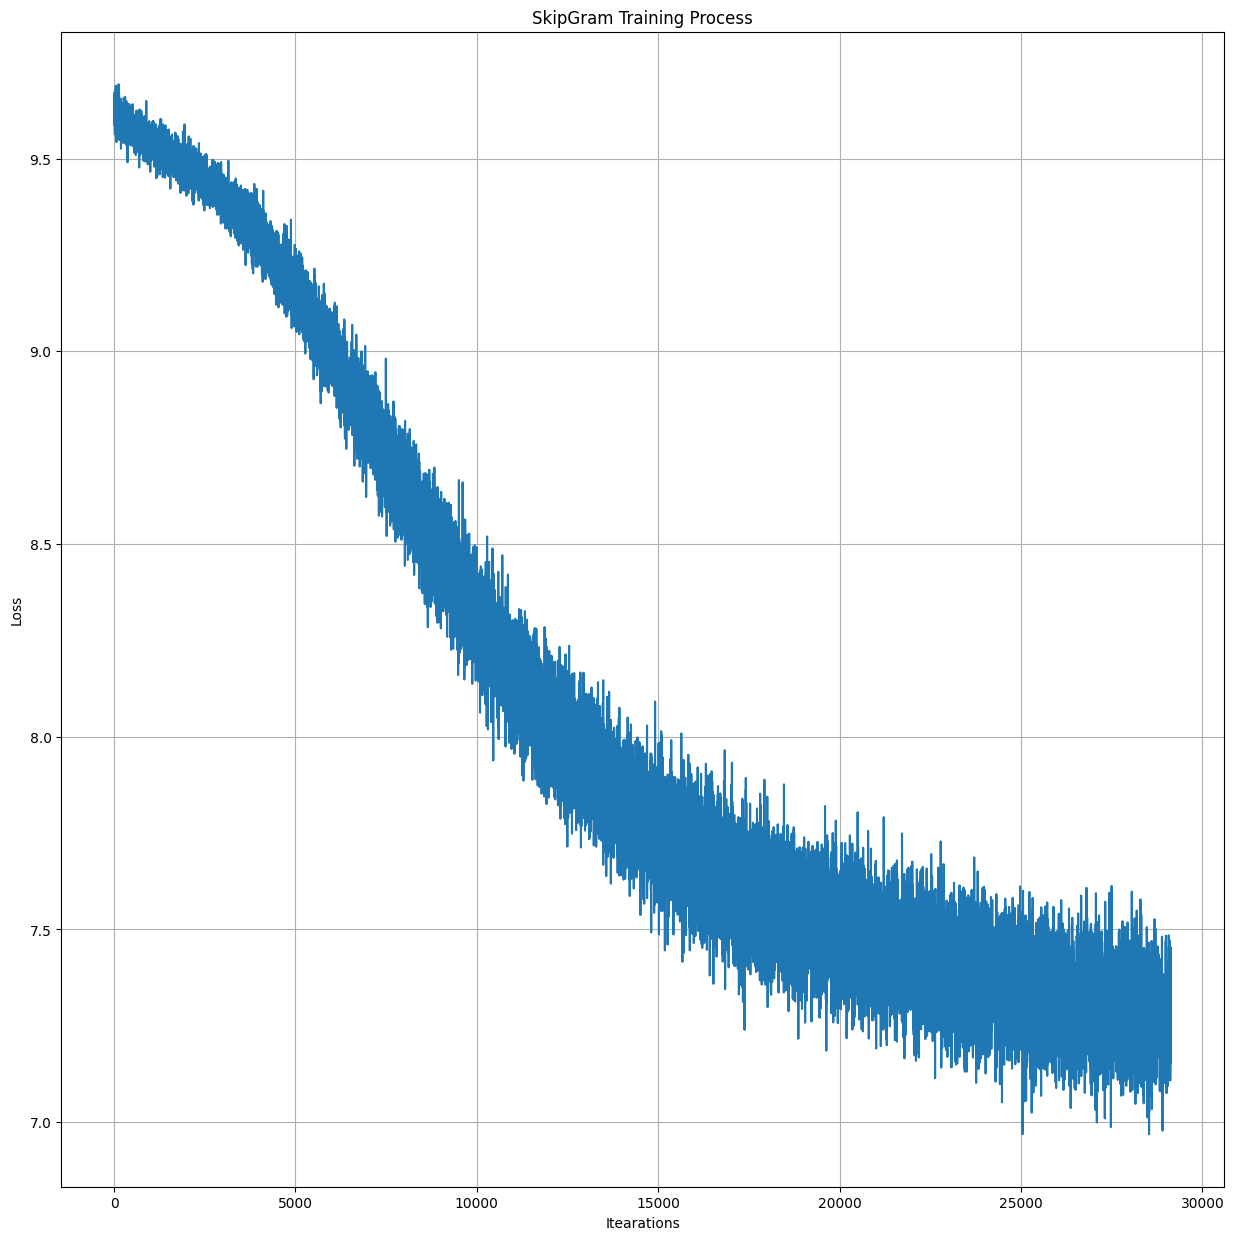

In [106]:
plt.title('SkipGram Training Process')
plt.xlabel('Itearations')
plt.ylabel('Loss')
plt.grid()
plt.plot(losses)

In [107]:
# проверка, что хоть что-то выучилось
assert np.mean(losses[-1000:]) < 7.5

In [108]:
embedding_matrix = model.in_embedding.weight.detach()

In [176]:
def cos_sim(embedding_matrix, token2id, word1, word2):

    if word1 in token2id.keys() and word2 in token2id.keys():
        i1 = token2id[word1]
        i2 = token2id[word2]
    else:
        return 0
    
    v1, v2 = embedding_matrix[i1], embedding_matrix[i2]
    
    v1_n = v1.div(v1.norm(keepdim=True))
    v2_n = v2.div(v2.norm(keepdim=True))
    
    similarity = torch.dot(v1_n, v2_n).item()
    
    return similarity

# Косинусная близость
От 0 до 1, где 0 - вектора абсолютно разные, где 1 - идентичные.

In [123]:
cos_sim(embedding_matrix, word2index, 'день', 'месяц')

0.3223838210105896

In [124]:
cos_sim(embedding_matrix, word2index, 'минута', 'месяц')

0.47313567996025085

In [125]:
cos_sim(embedding_matrix, word2index, 'сотрудник', 'сотрудница')

0.3505863845348358

In [126]:
cos_sim(embedding_matrix, word2index, 'вклад', 'перевод')

0.2645464539527893

In [136]:
cos_sim(embedding_matrix, word2index, 'перевод', 'доверенность')

0.6259104609489441

In [127]:
cos_sim(embedding_matrix, word2index, 'смеяться', 'плакать')

-0.24225185811519623

In [131]:
cos_sim(embedding_matrix, word2index, 'умный', 'глупый')

-0.18007385730743408

In [138]:
random_word = random.choice(list(word2index.keys()))
sim = cos_sim(embedding_matrix, word2index, 'день', random_word)
'Косинусная близость слова "день" к случайному выбраному слову "{}" равна {:.3f}'.format(random_word, sim)

'Косинусная близость слова "день" к случайному выбраному слову "забыться" равна 0.137'

In [117]:
freq = {}

for text in corpus:
    for token in text:
        if token in freq:
            freq[token] += 1
        else:
            freq[token] = 1

In [118]:
sorted_freq = [(k, freq[k]) for k in sorted(freq, key=freq.get, reverse=True)]
top_sorted_freq = sorted_freq[0:200]

In [119]:
tsne = TSNE(n_components=2, init='pca', random_state=42, verbose=2)
reduced = tsne.fit_transform(embedding_matrix.cpu())

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13076 samples in 0.001s...
[t-SNE] Computed neighbors for 13076 samples in 0.375s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13076
[t-SNE] Computed conditional probabilities for sample 2000 / 13076
[t-SNE] Computed conditional probabilities for sample 3000 / 13076
[t-SNE] Computed conditional probabilities for sample 4000 / 13076
[t-SNE] Computed conditional probabilities for sample 5000 / 13076
[t-SNE] Computed conditional probabilities for sample 6000 / 13076
[t-SNE] Computed conditional probabilities for sample 7000 / 13076
[t-SNE] Computed conditional probabilities for sample 8000 / 13076
[t-SNE] Computed conditional probabilities for sample 9000 / 13076
[t-SNE] Computed conditional probabilities for sample 10000 / 13076
[t-SNE] Computed conditional probabilities for sample 11000 / 13076
[t-SNE] Computed conditional probabilities for sample 12000 / 13076
[t-SNE] Computed conditional probabilities for sam

In [120]:
top_words = [a for a,_ in top_sorted_freq]

In [121]:
inds = [word2index[word] for word in top_words]
x_coords = [coords[0] for coords in reduced[inds]]
y_coords = [coords[1] for coords in reduced[inds]]

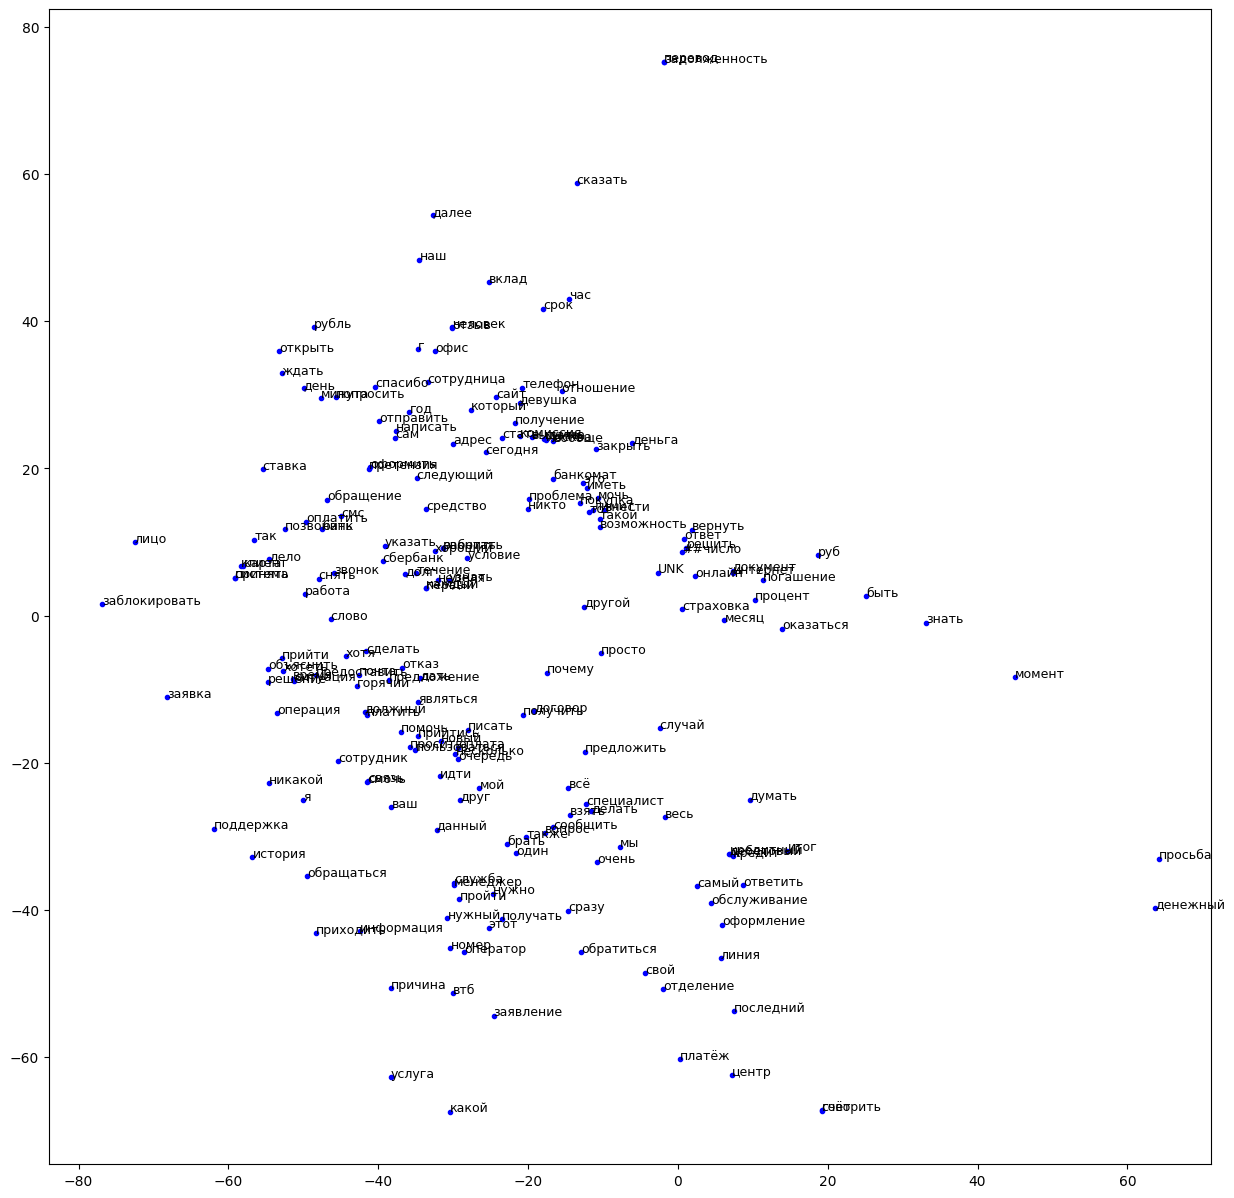

In [122]:
for (x, y, word) in zip(x_coords, y_coords, top_words):
    plt.scatter(x, y, marker='.', color='blue')
    plt.text(x+0.01, y+0.01, word, fontsize=9)
plt.show()

# Оценка
1. Вы добрались сюда и все работает, значит уже получили 7 баллов.
2. 8 баллов - Взяли корпус для оценка качества эмбеддингов [здесь](https://rusvectores.org/static/testsets/ru_simlex965_tagged.tsv). Описание к нему [здесь](https://arxiv.org/pdf/1801.06407.pdf). Его английская версия для понимания, того что же это такое [тут](https://fh295.github.io/simlex.html). Если в кратце - он похож а гугл аналогии, просто иначе составлен. Определили качество своих эмбеддингов. Как качество измерить? Можете все значения отнормировать (привести к 1) и затем считать MSE между тем что у вас и что в оригинале.
3. 9 баллов - Поставили эксперименты, поменяли любые параметры, хоть корпус увеличили или как то почистили. Показали метрики до и после. После должно быть лучше, иначе это все еще 8 баллов.
4. 10 баллов - удивили своим подходом (или просто удивили) пока делили на 9 баллов

In [163]:
import pandas as pd

In [164]:
etalon = pd.read_csv('data.csv', sep='\t')

In [165]:
etalon.columns = ['word1', 'word2', 'score']

In [166]:
etalon.score.min(),etalon.score.max(),

(0.0, 10.0)

In [167]:
### Косинусная близость принимает значения от -1 до 1
etalon.score = (etalon.score / 10) * 2 - 1

In [168]:
etalon.score.min(),etalon.score.max(),

(-1.0, 1.0)

In [171]:
etalon.word1 = etalon.word1.apply(lambda x: x.split('_')[0])
etalon.word2 = etalon.word2.apply(lambda x: x.split('_')[0])

In [172]:
etalon

,word1,word2,score
0,авария,бедствие,0.230
1,август,месяц,-0.430
2,авиация,полет,0.354
3,автомобиль,гудок,-0.630
4,автомобиль,автострада,-0.754
...,...,...,...
960,яблоко,солнце,-0.970
961,ядро,пушка,-0.446
962,язык,горло,-0.724
963,ярд,дюйм,-0.476


In [174]:
### Теперь посчитаем для каждой пары слов нашу оценку

In [188]:
etalon['our_score'] = etalon.apply(lambda x: cos_sim(embedding_matrix, word2index, x.word1, x.word2), axis=1)
etalon['se'] = (etalon.our_score-etalon.score)**2
etalon['ae'] = (etalon.our_score-etalon.score).abs()

In [189]:
mse = etalon.se.mean()
mae = etalon.ae.mean()

In [190]:
### Средняя квадратическая ошибка
mse

0.4742470470950418

In [191]:
### Средняя квадратическая ошибка
mae

0.5915139062402831

In [83]:
### Попробуем улучшить качество за счет увеличения размера окна, кол-ва элементов в эмбеддинг слое

In [84]:
EMBEDDING_DIM = 40
dataset = SkipgramDataset(corpus, word2index, window=3)
dataset_loader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)
model = SkipGram(vocab_size=len(word2index), embedding_dim=EMBEDDING_DIM)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', min_lr=0.00001, factor=0.5, verbose=True, patience=100000)
# aka loss function
criterion = torch.nn.CrossEntropyLoss()
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
epochs = 5
losses = []
model.to(device)

100%|██████████| 100000/100000 [00:00<00:00, 130396.79it/s]


SkipGram(
  (in_embedding): Embedding(13076, 40)
  (out_embedding): Linear(in_features=40, out_features=13076, bias=False)
)

In [85]:
for n_epoch in range(epochs):
    try:
        progress_bar = tqdm(total=len(dataset_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))
        for x, y in dataset_loader:
            optimizer.zero_grad()

            x = x.to(device)
            y = y.to(device)
            prediction = model(x)


            loss = criterion(prediction, y)
            loss.backward()
            optimizer.step()
            scheduler.step(loss)
            # CODE

            losses.append(loss.cpu().detach().numpy().item())

            progress_bar.set_postfix(loss=np.mean(losses[-100:]))

            progress_bar.update(x.shape[0])

        progress_bar.close()

    except KeyboardInterrupt:

        progress_bar.close()
        break

Epoch 5: 100%|██████████| 4174732/4174732 [01:10<00:00, 59249.51it/s, loss=7.1] 


In [86]:
embedding_matrix = model.in_embedding.weight.detach()
def cos_sim(embedding_matrix, token2id, word1, word2):

    if word1 in token2id.keys() and word2 in token2id.keys():
        i1 = token2id[word1]
        i2 = token2id[word2]
    else:
        return 0

    v1, v2 = embedding_matrix[i1], embedding_matrix[i2]

    v1_n = v1.div(v1.norm(keepdim=True))
    v2_n = v2.div(v2.norm(keepdim=True))

    similarity = torch.dot(v1_n, v2_n).item()

    return similarity

In [87]:
import pandas as pd
etalon = pd.read_csv('data.csv', sep='\t')
etalon.columns = ['word1', 'word2', 'score']
etalon.score = (etalon.score / 10) * 2 - 1
etalon.word1 = etalon.word1.apply(lambda x: x.split('_')[0])
etalon.word2 = etalon.word2.apply(lambda x: x.split('_')[0])
etalon['our_score'] = etalon.apply(lambda x: cos_sim(embedding_matrix, word2index, x.word1, x.word2), axis=1)
etalon['se'] = (etalon.our_score-etalon.score)**2
etalon['ae'] = (etalon.our_score-etalon.score).abs()
mse = etalon.se.mean()
mae = etalon.ae.mean()

In [88]:
### Средняя квадратическая ошибка
mse

0.44375619556429236

In [89]:
### Средняя квадратическая ошибка
mae

0.5782029651675947

In [82]:
### Скор улучшился